In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

import lightgbm as lgb

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import seaborn as sns
sns.set(font="IPAexGothic")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Read (Titanic)

In [13]:
train_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test.csv')

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Make Features

In [14]:
# Not sure passenger ID is useful as a feature, but need to save it from the test set for the submission
test_passenger_ids = test_df.pop('PassengerId')
train_df.drop(['PassengerId'], axis=1, inplace=True)

# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df['Embarked'].fillna('Null'))

# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)
    
    # Transform 'Embarked'
    df['Embarked'].fillna('Null', inplace=True)
    df['Embarked'] = embarked_encoder.transform(df['Embarked'])
    
    # Transform 'Sex'
    df.loc[df['Sex'] == 'female','Sex'] = 0
    df.loc[df['Sex'] == 'male','Sex'] = 1
    df['Sex'] = df['Sex'].astype('int8')
    
    # Drop features that seem unusable. Save passenger ids if test
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 3. Prepare

In [15]:
# Separate the label
y = train_df.pop('Survived')

# Take a hold out set randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgb.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)

In [25]:
lgb_params = {
    'boosting': 'gbdt', #'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
              }

In [28]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                 params=lgb_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=1000,
                 early_stopping_rounds=60,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

C:\Users\dicek\Miniconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 60 rounds.
[20]	Train's binary_logloss: 0.460192	Test's binary_logloss: 0.506581
[40]	Train's binary_logloss: 0.374571	Test's binary_logloss: 0.439066
[60]	Train's binary_logloss: 0.330562	Test's binary_logloss: 0.413485
[80]	Train's binary_logloss: 0.302086	Test's binary_logloss: 0.407346
[100]	Train's binary_logloss: 0.277797	Test's binary_logloss: 0.41022
[120]	Train's binary_logloss: 0.255749	Test's binary_logloss: 0.410554
[140]	Train's binary_logloss: 0.238341	Test's binary_logloss: 0.413666
Early stopping, best iteration is:
[84]	Train's binary_logloss: 0.296711	Test's binary_logloss: 0.40509


# 4. Visualise training

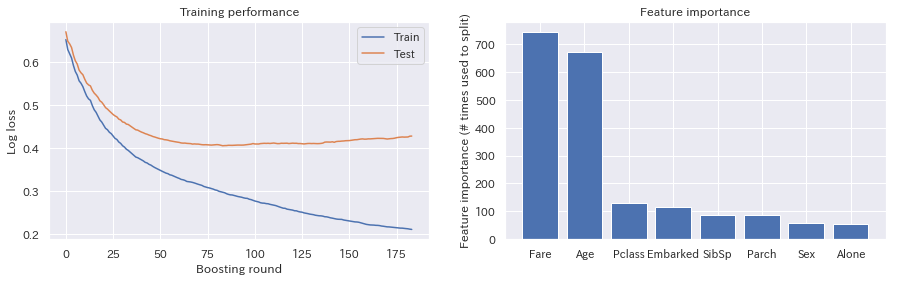

In [27]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()